# Deep Hedging sous Black-Scholes et Merton Jump-Diffusion

Ce notebook orchestre le pipeline complet de Deep Hedging en utilisant le package `deep_hedging/`.

### Pipeline
1. **Configuration** des parametres de marche et d'entrainement
2. **Visualisation** des trajectoires simulees
3. **Training** du modele neuronal (Black-Scholes puis Merton)
4. **Evaluation** multi-scenarios : BS→BS, BS→Merton, Merton→Merton
5. **Analyse de risque** : VaR, CVaR, KDE, QQ-plot
6. **Tableau de synthese** colore (traffic light)

## 1. Imports et Configuration

In [12]:
import numpy as np
import torch
from dataclasses import replace

from deep_hedging import (
    DEVICE, DTYPE,
    DeepHedgingConfig, MarketConfig, TrainingConfig, RandomConfig,
    SimpleWorldBS, SimpleWorldMerton,
    DeepHedgingEnv, PolicyMLP, DeltaBSPolicy,
    MonetaryUtility,
    train_deep_hedging,
    evaluate_strategies_env_world, build_comparison_table,
    RiskMetrics,
    plot_training_history, plot_gains_hist, plot_payoff_vs_gains,
    plot_simulated_paths, traffic_light_style,
)

print(f"Device: {DEVICE}, dtype: {DTYPE}")

Device: mps, dtype: torch.float32


## 2. Configuration globale

In [13]:
cfg = DeepHedgingConfig()
print(f"Marche  : S0={cfg.market.S0}, sigma={cfg.market.sigma}, K={cfg.market.K}")
print(f"Merton  : jumps={cfg.market.use_jumps}, lambda={cfg.market.lambda_jump}")
print(f"Training: epochs={cfg.training.n_epochs}, batch={cfg.training.batch_size}")
print(f"CVaR alpha={cfg.training.cvar_alpha}")

Marche  : S0=100.0, sigma=0.2, K=100.0
Merton  : jumps=True, lambda=1.0
Training: epochs=50, batch=10000
CVaR alpha=0.025


## 3. Visualisation des trajectoires simulees

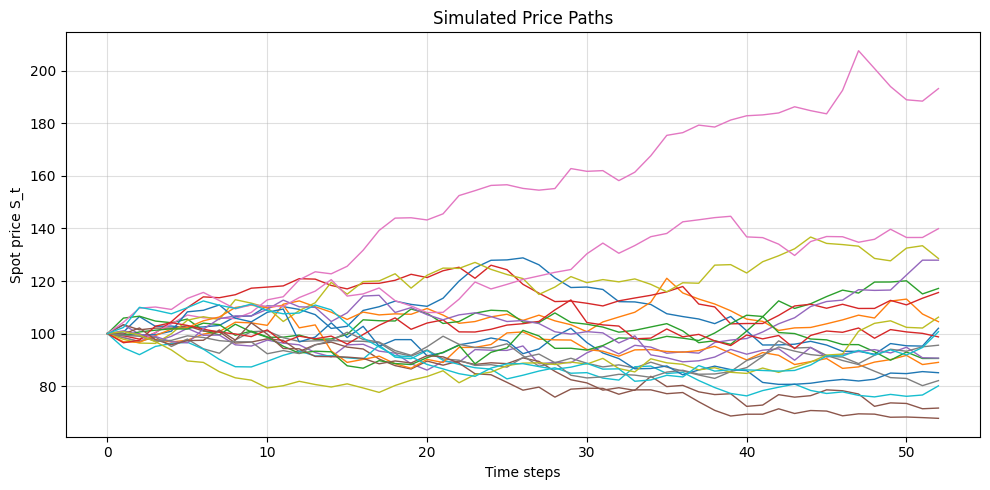

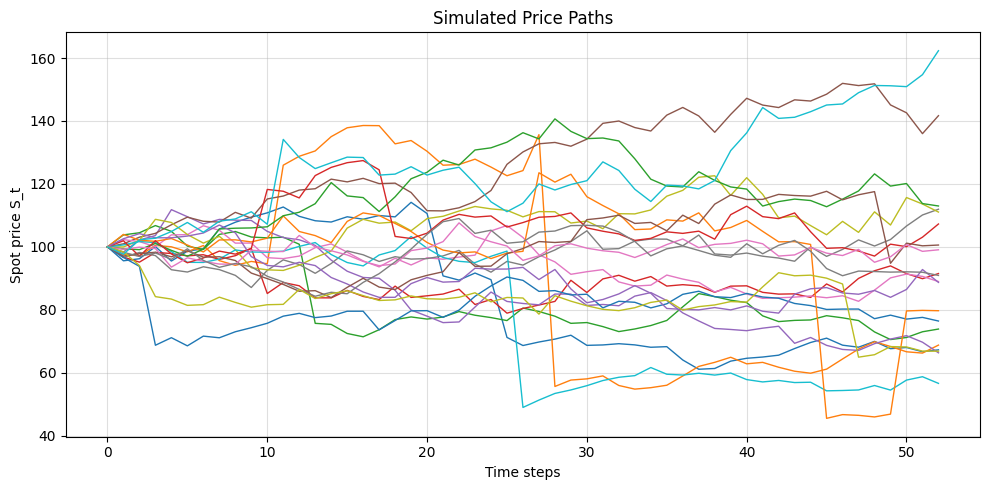

In [14]:
# Trajectoires Black-Scholes
world_bs = SimpleWorldBS(cfg.market)
data_bs = world_bs.simulate_paths(200, seed=42)
plot_simulated_paths(data_bs["S"], n_paths_to_plot=20)

# Trajectoires Merton
world_merton = SimpleWorldMerton(cfg.market)
data_merton = world_merton.simulate_paths(200, seed=42)
plot_simulated_paths(data_merton["S"], n_paths_to_plot=20)

## 4. Training Deep Hedging

### 4.1 Entrainement sous Black-Scholes

Epoch   5/50 | train_loss=2.983293 | val_loss=0.286088 | patience=0/5
Epoch  10/50 | train_loss=0.713793 | val_loss=1.228872 | patience=5/5
Early stopping a l'epoch 10.
Training BS termine.


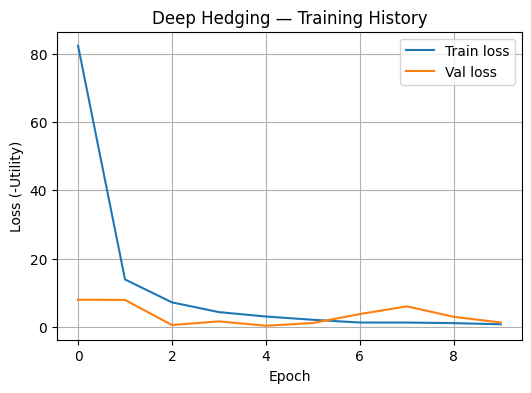

In [15]:
cfg_bs = DeepHedgingConfig(
    market=replace(cfg.market, use_jumps=False),
    training=cfg.training,
    random=cfg.random,
    device=cfg.device,
    dtype=cfg.dtype,
)

policy_bs = PolicyMLP(d_in=2, d_hidden=32, depth=2, dropout=0.1)

res_train_bs = train_deep_hedging(
    cfg_bs,
    policy_bs,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_bs.training.cvar_alpha),
    patience=5,
    min_delta=1e-3,
)

print("Training BS termine.")
plot_training_history(res_train_bs["history"])

### 4.2 Entrainement sous Merton (avec sauts)

Epoch   5/50 | train_loss=1.409686 | val_loss=-0.087014 | patience=0/5
Epoch  10/50 | train_loss=0.217936 | val_loss=-0.497311 | patience=1/5
Epoch  15/50 | train_loss=-0.496758 | val_loss=-0.936655 | patience=0/5
Epoch  20/50 | train_loss=-0.676005 | val_loss=-1.132835 | patience=0/5
Epoch  25/50 | train_loss=-0.880415 | val_loss=-1.228935 | patience=2/5
Epoch  30/50 | train_loss=-1.133247 | val_loss=-1.382677 | patience=1/5
Early stopping a l'epoch 34.
Training Merton termine.


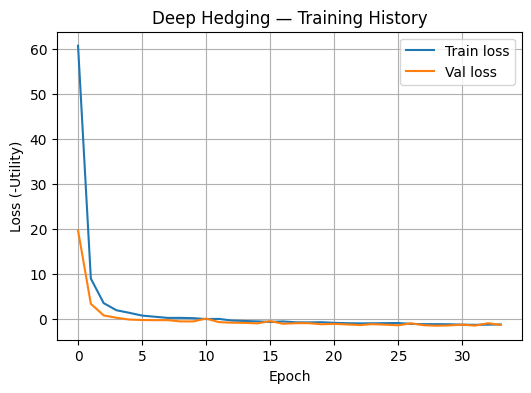

In [16]:
cfg_merton = DeepHedgingConfig(
    market=replace(cfg.market, use_jumps=True),
    training=cfg.training,
    random=cfg.random,
    device=cfg.device,
    dtype=cfg.dtype,
)

policy_merton = PolicyMLP(d_in=2, d_hidden=32, depth=2, dropout=0.1)

res_train_merton = train_deep_hedging(
    cfg_merton,
    policy_merton,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_merton.training.cvar_alpha),
    patience=5,
    min_delta=1e-3,
)

print("Training Merton termine.")
plot_training_history(res_train_merton["history"])

## 5. Evaluation multi-scenarios

Trois scenarios :
- **BS → BS** : entrainement et test sous Black-Scholes
- **BS → Merton** : entrainement BS, test avec sauts
- **Merton → Merton** : entrainement et test avec sauts

### 5.1 BS → BS

=== BS -> BS ===
CVaR Deep  : -0.3000
CVaR Delta : -10.7183
Std  Deep  : 9.0895
Std  Delta : 30.1610


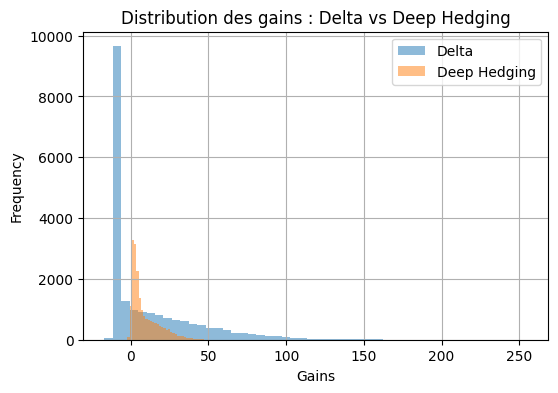

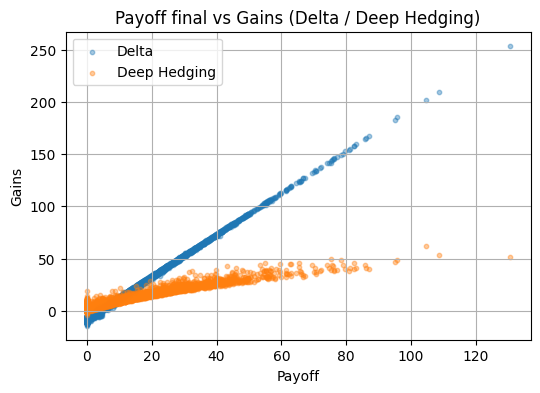

In [17]:
eval_bs_bs = evaluate_strategies_env_world(
    cfg_bs,
    res_train_bs["policy"],
    world_class=SimpleWorldBS,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs,
)

print("=== BS -> BS ===")
print(f"CVaR Deep  : {eval_bs_bs['cvar_deep']:.4f}")
print(f"CVaR Delta : {eval_bs_bs['cvar_delta']:.4f}")
print(f"Std  Deep  : {eval_bs_bs['std_deep']:.4f}")
print(f"Std  Delta : {eval_bs_bs['std_delta']:.4f}")

plot_gains_hist(eval_bs_bs)
plot_payoff_vs_gains(eval_bs_bs)

### 5.2 BS → Merton

=== BS -> Merton ===
CVaR Deep  : -3.0538
CVaR Delta : -43.3814
Std  Deep  : 17.3568
Std  Delta : 55.6010


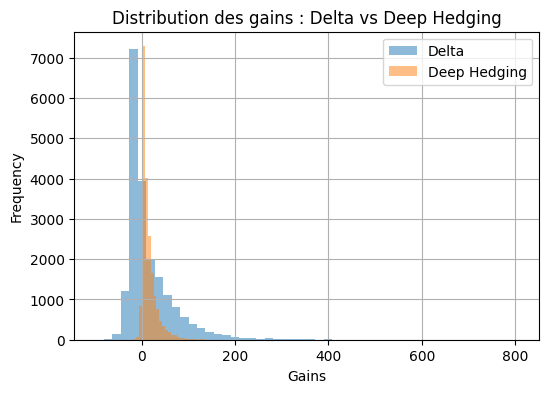

In [18]:
eval_bs_merton = evaluate_strategies_env_world(
    cfg_bs,
    res_train_bs["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs_merton,
)

print("=== BS -> Merton ===")
print(f"CVaR Deep  : {eval_bs_merton['cvar_deep']:.4f}")
print(f"CVaR Delta : {eval_bs_merton['cvar_delta']:.4f}")
print(f"Std  Deep  : {eval_bs_merton['std_deep']:.4f}")
print(f"Std  Delta : {eval_bs_merton['std_delta']:.4f}")

plot_gains_hist(eval_bs_merton)

### 5.3 Merton → Merton

=== Merton -> Merton ===
CVaR Deep  : 1.4667
CVaR Delta : -43.3814
Std  Deep  : 13.5183
Std  Delta : 55.6010


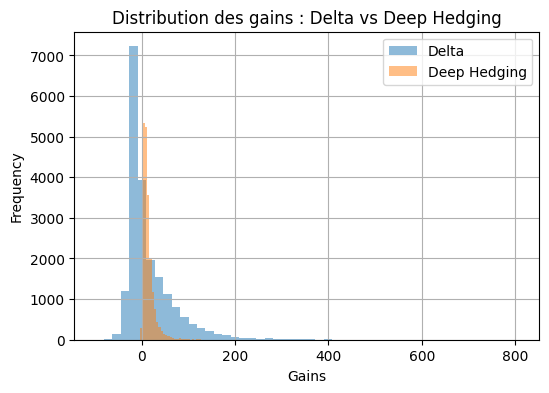

In [19]:
eval_merton_merton = evaluate_strategies_env_world(
    cfg_merton,
    res_train_merton["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_merton.random.seed_eval_merton,
)

print("=== Merton -> Merton ===")
print(f"CVaR Deep  : {eval_merton_merton['cvar_deep']:.4f}")
print(f"CVaR Delta : {eval_merton_merton['cvar_delta']:.4f}")
print(f"Std  Deep  : {eval_merton_merton['std_deep']:.4f}")
print(f"Std  Delta : {eval_merton_merton['std_delta']:.4f}")

plot_gains_hist(eval_merton_merton)

## 6. Analyse de risque detaillee

Utilisation de `RiskMetrics` pour les distributions de gains.

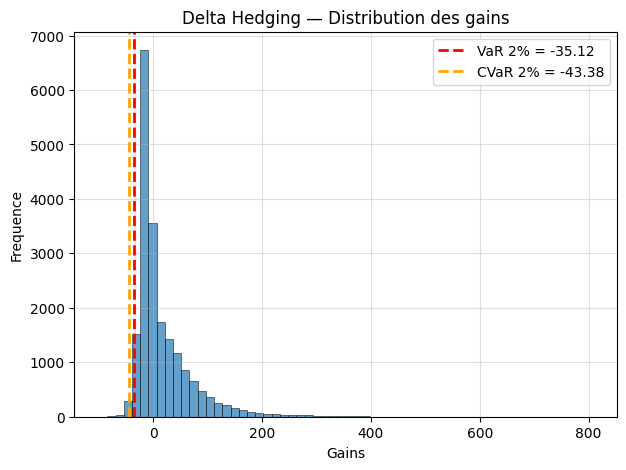

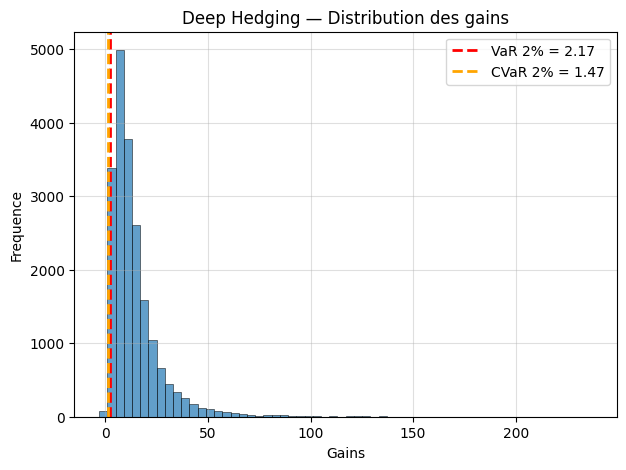

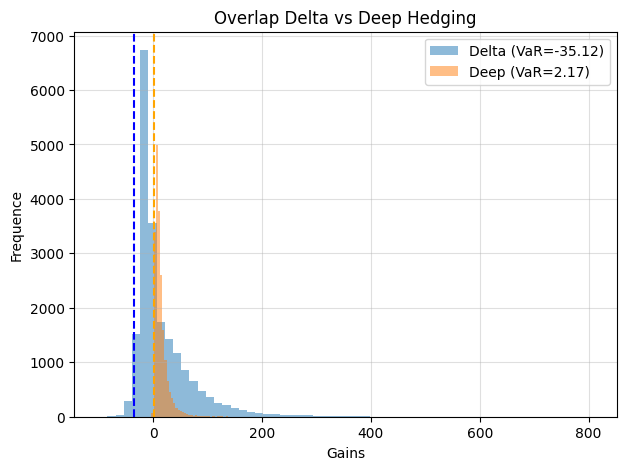

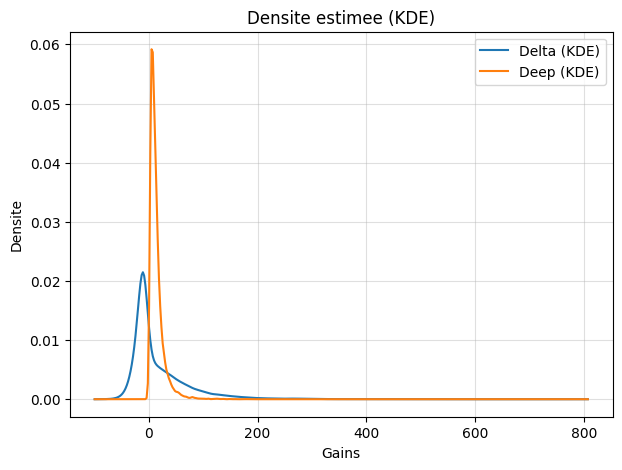

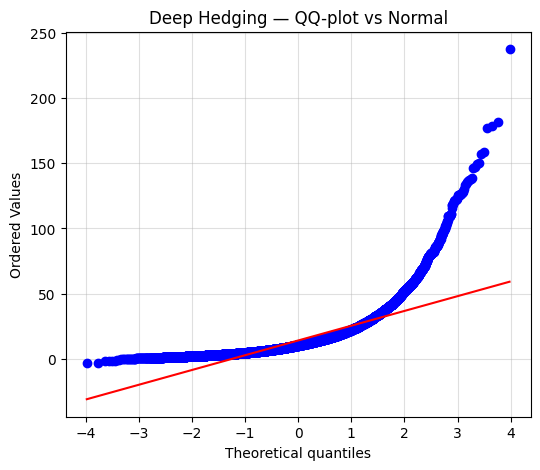

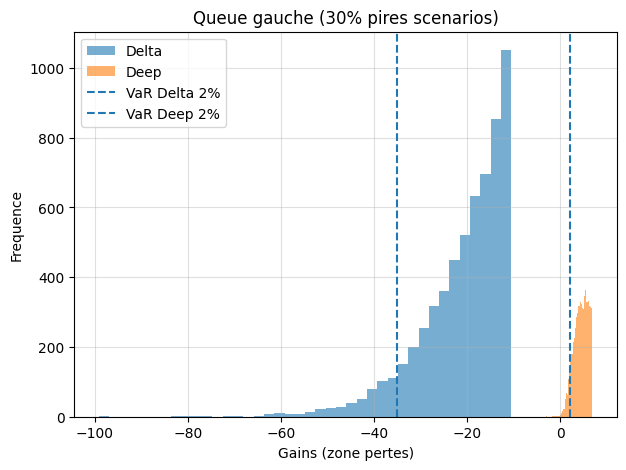

In [20]:
rm = RiskMetrics(alpha=cfg.training.cvar_alpha)

# Prendre le scenario Merton->Merton comme exemple
gains_delta = eval_merton_merton["gains_delta"]
gains_deep  = eval_merton_merton["gains_deep"]

# Histogrammes avec VaR
rm.plot_hist_with_var(gains_delta, title="Delta Hedging — Distribution des gains")
rm.plot_hist_with_var(gains_deep,  title="Deep Hedging — Distribution des gains")

# Overlap
rm.plot_overlap_with_var(gains_delta, gains_deep, label_a="Delta", label_b="Deep")

# KDE
rm.plot_kde(gains_delta, gains_deep, label_a="Delta", label_b="Deep")

# QQ-Plot
rm.plot_qq(gains_deep, title="Deep Hedging — QQ-plot vs Normal")

# Queue gauche
rm.plot_left_tail(gains_delta, gains_deep, label_a="Delta", label_b="Deep")

## 7. Tableau de synthese

Comparaison coloree (vert/orange/rouge) de tous les scenarios.

In [21]:
import pandas as pd

# Tableaux par scenario
table_bs_bs = build_comparison_table(cfg_bs, eval_bs_bs).copy()
table_bs_bs.insert(0, "Scenario", "BS -> BS")

table_bs_merton = build_comparison_table(cfg_bs, eval_bs_merton).copy()
table_bs_merton.insert(0, "Scenario", "BS -> Merton")

table_merton_merton = build_comparison_table(cfg_merton, eval_merton_merton).copy()
table_merton_merton.insert(0, "Scenario", "Merton -> Merton")

# Concatenation
summary_df = pd.concat([table_bs_bs, table_bs_merton, table_merton_merton], axis=0)
summary_df = summary_df.reset_index().rename(columns={"index": "Strategy"})
summary_df = summary_df.set_index(["Scenario", "Strategy"])

# Colonnes metriques
metric_cols = [c for c in summary_df.columns if c != "Scenario"]
summary_metrics = summary_df[metric_cols].astype(float)

# Affichage avec code couleur
styled_summary = (
    summary_metrics
    .style
    .apply(traffic_light_style, axis=None)
    .format("{:.3f}")
)

display(styled_summary)

## 8. Sauvegarde des modeles

In [22]:
torch.save({
    "policy_bs_state": res_train_bs["policy"].state_dict(),
    "policy_merton_state": res_train_merton["policy"].state_dict(),
    "config_bs": cfg_bs,
    "config_merton": cfg_merton,
    "history_bs": res_train_bs["history"],
    "history_merton": res_train_merton["history"],
}, "deep_hedging_models.pt")

print("Modeles sauvegardes dans 'deep_hedging_models.pt'")

Modeles sauvegardes dans 'deep_hedging_models.pt'


## Conclusion

Ce notebook a orchestre le pipeline complet de Deep Hedging :

- Simulation Black-Scholes et Merton Jump-Diffusion
- Entrainement neuronal avec optimisation CVaR
- Evaluation multi-scenarios (BS->BS, BS->Merton, Merton->Merton)
- Analyse de risque detaillee (VaR, CVaR, KDE, QQ-plot)
- Tableau de synthese colore

### Structure du code

```
deep_hedging/
  __init__.py      # Public API
  config.py        # Configurations (MarketConfig, TrainingConfig, ...)
  worlds.py        # Simulateurs (SimpleWorldBS, SimpleWorldMerton)
  env.py           # Environnement de hedging (DeepHedgingEnv)
  policies.py      # Politiques (PolicyMLP, DeltaBSPolicy)
  losses.py        # Utilitaires monetaires (MonetaryUtility, CVaR)
  training.py      # Boucle d'entrainement
  evaluation.py    # Evaluation et comparaison
  risk_metrics.py  # Metriques de risque (RiskMetrics)
  plotting.py      # Visualisations
  utils.py         # Fonctions utilitaires
```